<a href="https://colab.research.google.com/github/nandinib1999/edureka-assignments/blob/main/Edureka_Sequence_Learning_Assignment_2_NER_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement

In Natural Language Processing (NLP), Entity Recognition is one of 
the common problems. NER is a method of extracting the relevant 
information from a large corpus and classifying those entities into 
predefined categories such as location, organization, name, and so 
on. 
In this problem you are given tagged data for entities, you have to 
predict those entities using LSTM models.

### Installing packages and loading data

In [ ]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 10.4MB/s 


In [ ]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [ ]:
data.head(10)

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O
5,5,through,london,to,TO,lowercase,to,NNP,capitalized,London,IN,O,march,VBN,O,have,VBP,lowercase,have,lowercase,marched,1.0,lowercase,through,O
6,6,london,to,protest,VB,lowercase,protest,TO,lowercase,to,NNP,O,through,IN,O,march,VBN,lowercase,marched,lowercase,through,1.0,capitalized,London,B-geo
7,7,to,protest,the,DT,lowercase,the,VB,lowercase,protest,TO,B-geo,london,NNP,O,through,IN,lowercase,through,capitalized,London,1.0,lowercase,to,O
8,8,protest,the,war,NN,lowercase,war,DT,lowercase,the,VB,O,to,TO,B-geo,london,NNP,capitalized,London,lowercase,to,1.0,lowercase,protest,O
9,9,the,war,in,IN,lowercase,in,NN,lowercase,war,DT,O,protest,VB,O,to,TO,lowercase,to,lowercase,protest,1.0,lowercase,the,O


In [ ]:
df = data.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
                'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
                'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
                'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
                'prev-prev-word', 'prev-shape', 'prev-word', "pos", "shape"], axis=1)

In [ ]:
df.columns

Index(['sentence_idx', 'word', 'tag'], dtype='object')

In [ ]:
df.head(10)

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O
5,1.0,through,O
6,1.0,London,B-geo
7,1.0,to,O
8,1.0,protest,O
9,1.0,the,O


In [ ]:
df.shape

(1050795, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   sentence_idx  1050794 non-null  float64
 1   word          1050794 non-null  object 
 2   tag           1050794 non-null  object 
dtypes: float64(1), object(2)
memory usage: 24.1+ MB


In [ ]:
df.isna().sum()

sentence_idx    1
word            1
tag             1
dtype: int64

In [ ]:
df = df[~df.isna().any(axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050794 entries, 0 to 1050794
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   sentence_idx  1050794 non-null  float64
 1   word          1050794 non-null  object 
 2   tag           1050794 non-null  object 
dtypes: float64(1), object(2)
memory usage: 32.1+ MB


In [ ]:
df.isna().sum()

sentence_idx    0
word            0
tag             0
dtype: int64

Upon checking the data manually, I saw that the sentences were repeated in the dataset. That's why I am deleting the duplicate rows from the dataframes for every repeated pair of "sentence index" and "word".

In [ ]:
df.drop_duplicates(subset =['sentence_idx','word'], keep = 'first', inplace = True)
df.shape

(715447, 3)

In [ ]:
df["tag"].value_counts()

O        600897
B-geo     26718
B-tim     14735
B-org     14504
I-per     12467
B-per     12140
I-org     11949
B-gpe     11221
I-geo      5176
I-tim      4403
B-art       287
B-eve       228
I-eve       196
I-art       185
B-nat       156
I-gpe       142
I-nat        43
Name: tag, dtype: int64

We can see that there is a class imbalance in the dataset for the tags. The number of words tagged as "O" surpasses the number of words tagged as the other classes.

### Loading all the sentences and the tags in a list

In [ ]:
grp_df = df.groupby('sentence_idx')

In [ ]:
import tqdm

all_sentences = []
max_len = 0
for sent_indx, sent_word_tags in tqdm.tqdm(grp_df, total=len(grp_df)):
  word_lst = sent_word_tags['word'].tolist()
  tag_lst = sent_word_tags['tag'].tolist()
  sent = [(word.lower(), tag) for word, tag in zip(word_lst, tag_lst)]
  if max_len < len(sent):
    max_len = len(sent)
  all_sentences.append(sent)

100%|██████████| 35177/35177 [00:04<00:00, 7368.83it/s]


In [ ]:
max_len

58

In [ ]:
all_sentences[1]

[('families', 'O'),
 ('of', 'O'),
 ('soldiers', 'O'),
 ('killed', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('conflict', 'O'),
 ('joined', 'O'),
 ('protesters', 'O'),
 ('who', 'O'),
 ('carried', 'O'),
 ('banners', 'O'),
 ('with', 'O'),
 ('such', 'O'),
 ('slogans', 'O'),
 ('as', 'O'),
 ('"', 'O'),
 ('bush', 'B-per'),
 ('number', 'O'),
 ('one', 'O'),
 ('terrorist', 'O'),
 ('and', 'O'),
 ('stop', 'O'),
 ('bombings', 'O'),
 ('.', 'O')]

#### Counting the unique words and tags in the dataset for mapping every word/tag to a unique index value

In [ ]:
words = list(set(df["word"].values))
words = [x.lower() for x in words]
words.append("EOS")

In [ ]:
n_words = len(words) 
n_words

30173

In [ ]:
tags = list(set(df["tag"].values))

In [ ]:
n_tags = len(tags) 
n_tags

17

In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

#### Padding all the sentences and sequence of tags to the length of the longest sentence in the dataset

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in all_sentences]

In [ ]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [ ]:
y = [[tag2idx[w[1]] for w in s] for s in all_sentences]

In [ ]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

#### Converting the tags to categorical data to feed into the model

In [ ]:
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

#### Splitting the data into train and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

#### Defining the four-layered model with BiLSTM

In [ ]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=max_len, input_length=max_len)(input)
model = Dropout(0.2)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

In [ ]:
model = Model(input, out)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 58)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 58, 58)            1750034   
_________________________________________________________________
dropout (Dropout)            (None, 58, 58)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 58, 200)           127200    
_________________________________________________________________
time_distributed (TimeDistri (None, 58, 17)            3417      
Total params: 1,880,651
Trainable params: 1,880,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!mkdir "saved_model"

#### Initializing some callbacks for model training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

es = EarlyStopping(monitor="val_loss", mode="min", patience=3)
checkpt = ModelCheckpoint("/content/saved_model", monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=128, epochs=200, validation_split=0.2, verbose=1, callbacks=[es, checkpt])

Epoch 1/200
176/176 [==============================] - 93s 375ms/step - loss: 0.8422 - accuracy: 0.9125 - val_loss: 0.2055 - val_accuracy: 0.9446

Epoch 00001: val_loss improved from inf to 0.20551, saving model to /content/saved_model
INFO:tensorflow:Assets written to: /content/saved_model/assets
Epoch 2/200
176/176 [==============================] - 65s 367ms/step - loss: 0.1780 - accuracy: 0.9492 - val_loss: 0.1313 - val_accuracy: 0.9605

Epoch 00002: val_loss improved from 0.20551 to 0.13130, saving model to /content/saved_model
INFO:tensorflow:Assets written to: /content/saved_model/assets
Epoch 3/200
176/176 [==============================] - 65s 369ms/step - loss: 0.1173 - accuracy: 0.9652 - val_loss: 0.0902 - val_accuracy: 0.9758

Epoch 00003: val_loss improved from 0.13130 to 0.09023, saving model to /content/saved_model
INFO:tensorflow:Assets written to: /content/saved_model/assets
Epoch 4/200
176/176 [==============================] - 64s 366ms/step - loss: 0.0782 - accuracy

#### Visualizing the accuracy and loss from model training

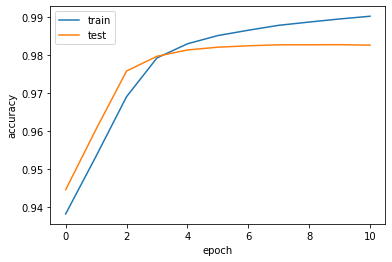

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

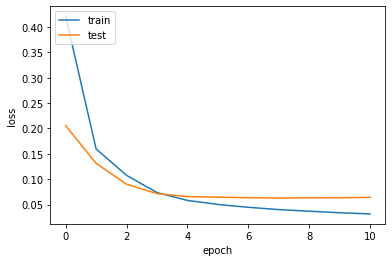

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Evaluating the model performance based on test data

In [ ]:
raw_test_predictions = model.predict(X_test)
test_pred = np.argmax(raw_test_predictions, axis=-1)

y_test_labels = np.argmax(y_test, axis=-1)

In [ ]:
test_pred[0]

array([1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [ ]:
y_test_labels[0]

array([ 1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9, 15,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8])

In [ ]:
import tensorflow as tf

test_pred_fl = tf.reshape(test_pred, (test_pred.shape[0]*test_pred.shape[1]))
test_pred_fl.shape

TensorShape([408088])

In [ ]:
y_test_labels_fl = tf.reshape(y_test_labels, (y_test_labels.shape[0]*y_test_labels.shape[1]))
y_test_labels_fl.shape

TensorShape([408088])

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

f1_score(y_test_labels_fl, test_pred_fl, average="weighted")

0.9820577018096401

In [ ]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w, true_tag, pred in zip(X_test[i], y_test_labels[i], p[0]):
    print("{:14}: {}\t {}".format(words[w], tags[true_tag], tags[pred]))

Word           (True ): Pred
pyongyang     : B-org	 B-org
is            : O	 O
demanding     : O	 O
seoul         : B-org	 B-org
pay           : O	 O
at            : O	 O
least         : O	 O
$             : O	 O
1             : O	 O
billion       : O	 O
in            : O	 O
compensation  : O	 O
for           : O	 O
allegedly     : O	 O
torturing     : O	 O
north         : O	 B-geo
korean        : B-gpe	 B-gpe
spies         : O	 O
and           : O	 O
prisoners     : O	 O
of            : O	 O
war           : O	 O
formerly      : O	 O
held          : O	 O
south         : B-geo	 B-geo
korea         : I-geo	 I-geo
.             : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS

#### Model 2

In [ ]:
input = Input(shape=(max_len,))
model_2 = Embedding(input_dim=n_words, output_dim=max_len, input_length=max_len)(input)
model_2 = Dropout(0.2)(model_2)
model_2 = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model_2)
output = TimeDistributed(Dense(n_tags, activation="softmax"))(model_2)

In [ ]:
model_2 = Model(input, output)

"focal loss" is most popularly used for training the model with imbalanced dataset

In [ ]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [ ]:
model_2.compile(optimizer="nadam", loss=focal_loss(alpha=1), metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 58)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 58, 58)            1750034   
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 58)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 58, 200)           127200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 58, 17)            3417      
Total params: 1,880,651
Trainable params: 1,880,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!mkdir "saved_model_2"

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

es = EarlyStopping(monitor="val_loss", mode="min", patience=3)
checkpt = ModelCheckpoint("/content/saved_model_2", monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [ ]:
history = model_2.fit(X_train, np.array(y_train), batch_size=128, epochs=200, validation_split=0.2, verbose=1, callbacks=[es, checkpt])

Epoch 1/200
176/176 [==============================] - 72s 372ms/step - loss: 0.3417 - accuracy: 0.9069 - val_loss: 0.1502 - val_accuracy: 0.9694

Epoch 00001: val_loss improved from inf to 0.15021, saving model to /content/saved_model_2
INFO:tensorflow:Assets written to: /content/saved_model_2/assets
Epoch 2/200
176/176 [==============================] - 64s 362ms/step - loss: 0.1341 - accuracy: 0.9714 - val_loss: 0.0993 - val_accuracy: 0.9794

Epoch 00002: val_loss improved from 0.15021 to 0.09925, saving model to /content/saved_model_2
INFO:tensorflow:Assets written to: /content/saved_model_2/assets
Epoch 3/200
176/176 [==============================] - 64s 365ms/step - loss: 0.0848 - accuracy: 0.9811 - val_loss: 0.0854 - val_accuracy: 0.9817

Epoch 00003: val_loss improved from 0.09925 to 0.08538, saving model to /content/saved_model_2
INFO:tensorflow:Assets written to: /content/saved_model_2/assets
Epoch 4/200
176/176 [==============================] - 65s 367ms/step - loss: 0.066

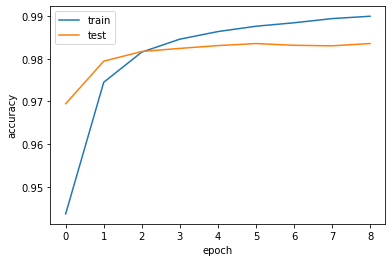

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

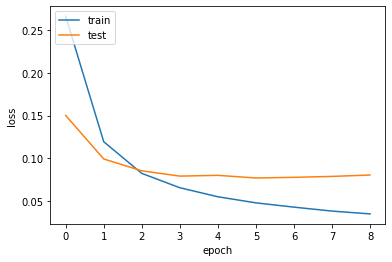

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Evaluating the model performance

In [ ]:
raw_test_predictions = model_2.predict(X_test)
test_pred = np.argmax(raw_test_predictions, axis=-1)   #taking index  of maximum probab

y_test_labels = np.argmax(y_test, axis=-1)

In [ ]:
import tensorflow as tf

test_pred_fl = tf.reshape(test_pred, (test_pred.shape[0]*test_pred.shape[1]))
test_pred_fl.shape

TensorShape([408088])

In [ ]:
y_test_labels_fl = tf.reshape(y_test_labels, (y_test_labels.shape[0]*y_test_labels.shape[1]))
y_test_labels_fl.shape

TensorShape([408088])

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

f1_score(y_test_labels_fl, test_pred_fl, average="weighted")

0.9831531934280401

In [ ]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w, true_tag, pred in zip(X_test[i], y_test_labels[i], p[0]):
    print("{:14}: {}\t {}".format(words[w], tags[true_tag], tags[pred]))

Word           (True ): Pred
the           : O	 O
miami         : B-geo	 B-geo
herald        : I-geo	 O
newspaper     : O	 O
reports       : O	 O
the           : O	 O
prison        : O	 O
upheaval      : O	 O
was           : O	 O
quashed       : O	 O
by            : O	 O
mid-afternoon : B-tim	 B-tim
when          : O	 O
u.n.          : B-org	 B-org
troops        : O	 O
blocked       : O	 O
off           : O	 O
streets       : O	 O
surrounding   : O	 O
.             : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 O
EOS           : O	 

#### Classification report for class-wise performance of the model

In [ ]:
y_pred = [[idx2tag[i] for i in row] for row in test_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_labels]

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report

report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.67      0.06      0.11        66
       B-eve       0.56      0.25      0.34        40
       B-geo       0.83      0.85      0.84      5464
       B-gpe       0.95      0.93      0.94      2239
       B-nat       0.43      0.23      0.30        26
       B-org       0.73      0.63      0.68      2931
       B-per       0.76      0.81      0.78      2409
       B-tim       0.88      0.87      0.87      2927
       I-art       0.00      0.00      0.00        40
       I-eve       0.47      0.24      0.32        33
       I-geo       0.79      0.68      0.73      1098
       I-gpe       0.80      0.48      0.60        25
       I-nat       0.17      0.14      0.15         7
       I-org       0.69      0.57      0.63      2361
       I-per       0.84      0.80      0.82      2487
       I-tim       0.80      0.65      0.71       878
           O       0.99      1.00      0.99    385057

    accuracy              

### **Final Remarks**

I think the model performance in both the cases is acceptable as we are using the conservative approach of BiLSTM modelling for NER task. To improve the performance furthermore, we can make use of CRF layers along with BiLSTMs in the model. It is the SOTA in the field of NLP-NER tasks.